<a href="https://colab.research.google.com/github/antonioomodho/Applied-Machine-Learning/blob/main/MLAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

        network_packet_size protocol_type  login_attempts  session_duration  \
count           9537.000000          9537     9537.000000       9537.000000   
unique                  NaN             3             NaN               NaN   
top                     NaN           TCP             NaN               NaN   
freq                    NaN          6624             NaN               NaN   
mean             500.430639           NaN        4.032086        792.745312   
std              198.379364           NaN        1.963012        786.560144   
min               64.000000           NaN        1.000000          0.500000   
25%              365.000000           NaN        3.000000        231.953006   
50%              499.000000           NaN        4.000000        556.277457   
75%              635.000000           NaN        5.000000       1105.380602   
max             1285.000000           NaN       13.000000       7190.392213   

       encryption_used  ip_reputation_score  failed

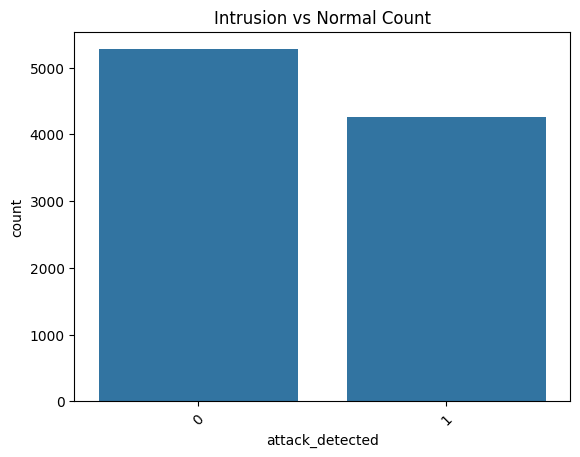


Class Distribution:
 attack_detected
0    5273
1    4264
Name: count, dtype: int64

--- Logistic Regression WITHOUT Scaling ---
[No Scaling] Top 1 features -> Time: 0.0367s | Acc: 0.5529, Prec: 0.6000, Recall: 0.0450, F1: 0.0838, AUC: 0.4974
[No Scaling] Top 2 features -> Time: 0.0378s | Acc: 0.6268, Prec: 0.5842, Recall: 0.6166, F1: 0.6000, AUC: 0.6950
[No Scaling] Top 3 features -> Time: 0.0367s | Acc: 0.7238, Prec: 0.7275, Recall: 0.6259, F1: 0.6729, AUC: 0.7767
[No Scaling] Top 4 features -> Time: 0.0395s | Acc: 0.7390, Prec: 0.7383, Recall: 0.6582, F1: 0.6960, AUC: 0.7904
[No Scaling] Top 5 features -> Time: 0.0443s | Acc: 0.7421, Prec: 0.7448, Recall: 0.6570, F1: 0.6982, AUC: 0.7896
[No Scaling] Top 6 features -> Time: 0.0427s | Acc: 0.7479, Prec: 0.7484, Recall: 0.6697, F1: 0.7069, AUC: 0.8114
[No Scaling] Top 7 features -> Time: 0.0520s | Acc: 0.7469, Prec: 0.7477, Recall: 0.6674, F1: 0.7053, AUC: 0.8104
[No Scaling] Top 8 features -> Time: 0.0514s | Acc: 0.7479, Prec: 0.7510,

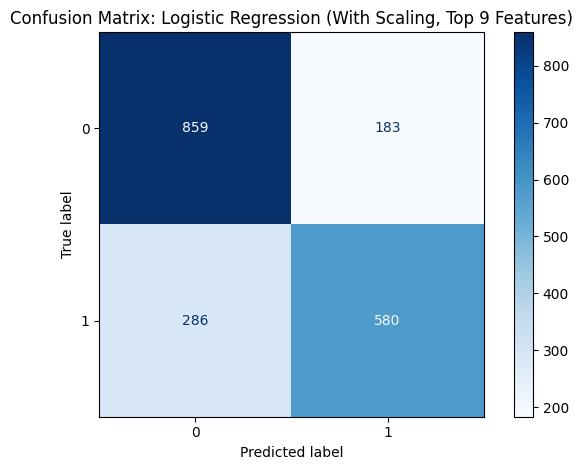


Feature Importances (With Scaling, Top 9 Features):
                            Importance
cat__protocol_type_ICMP      -0.135999
cat__encryption_used_AES     -0.116627
cat__encryption_used_nan      0.043636
cat__browser_type_Chrome     -0.033844
cat__browser_type_Unknown     1.698202
scale__login_attempts         4.614915
scale__session_duration       0.790183
scale__ip_reputation_score    2.862345
scale__failed_logins          4.683761


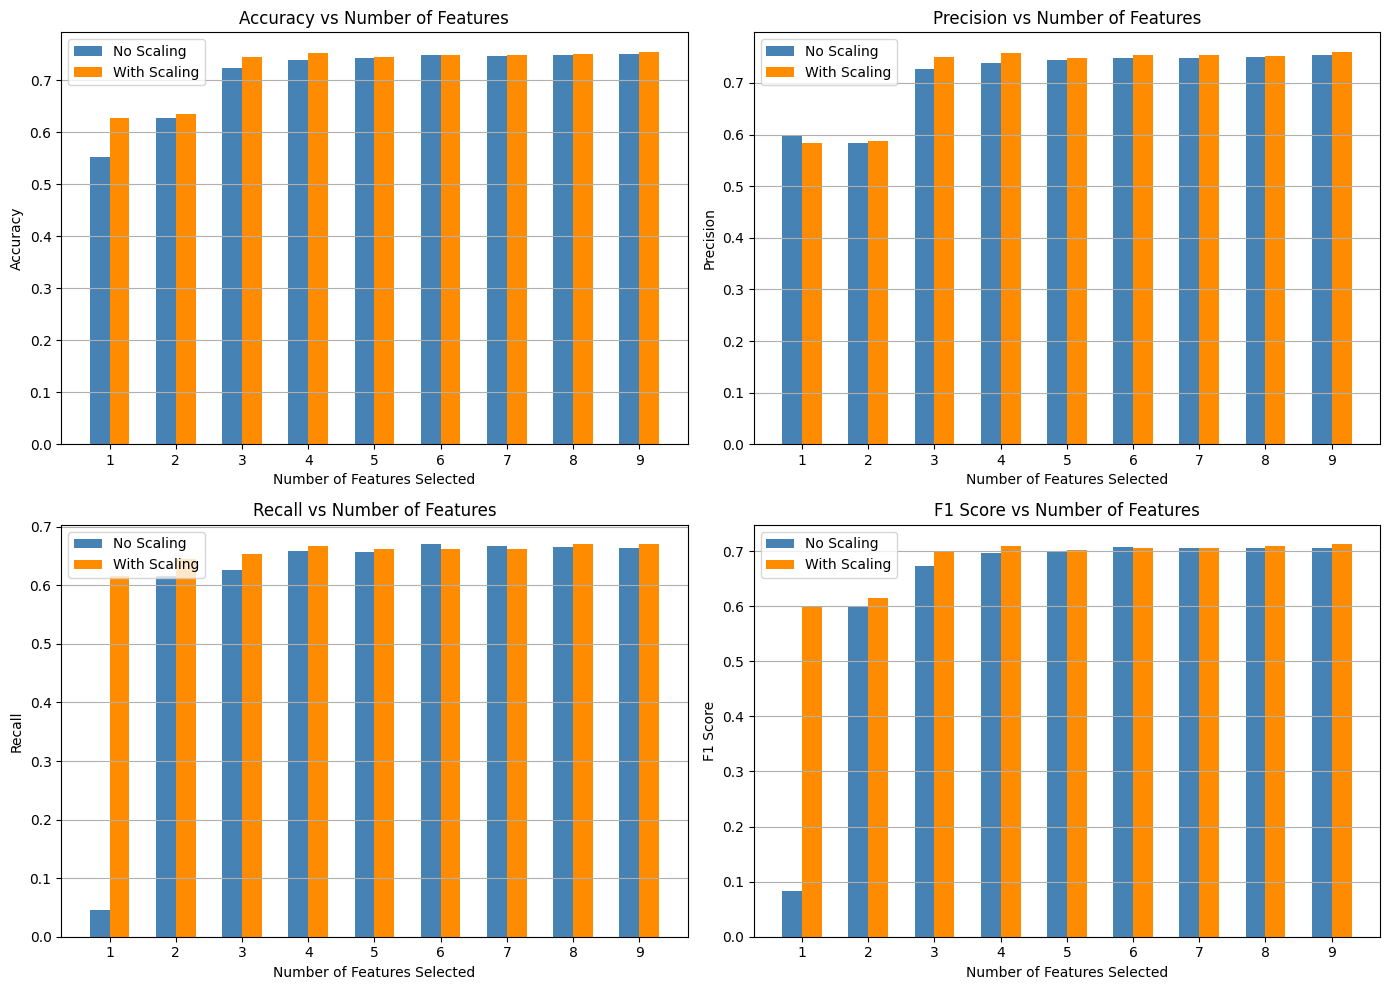

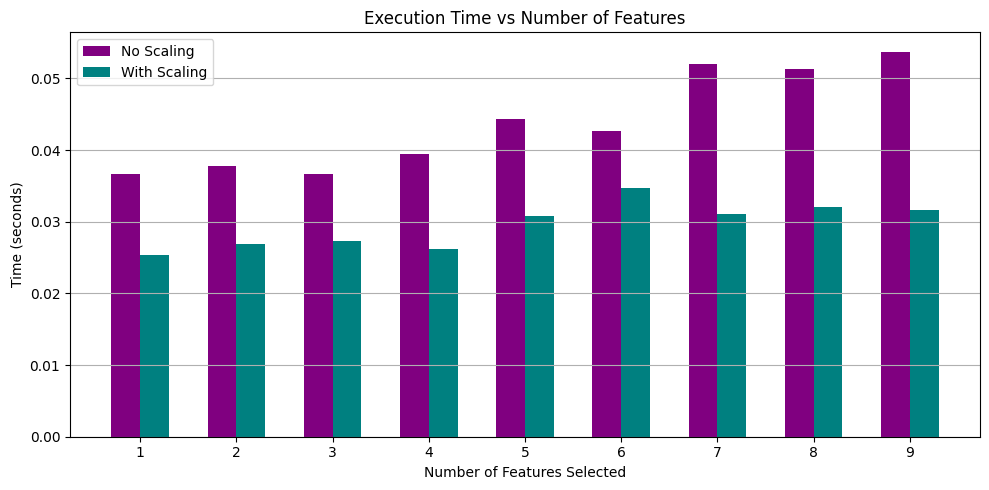

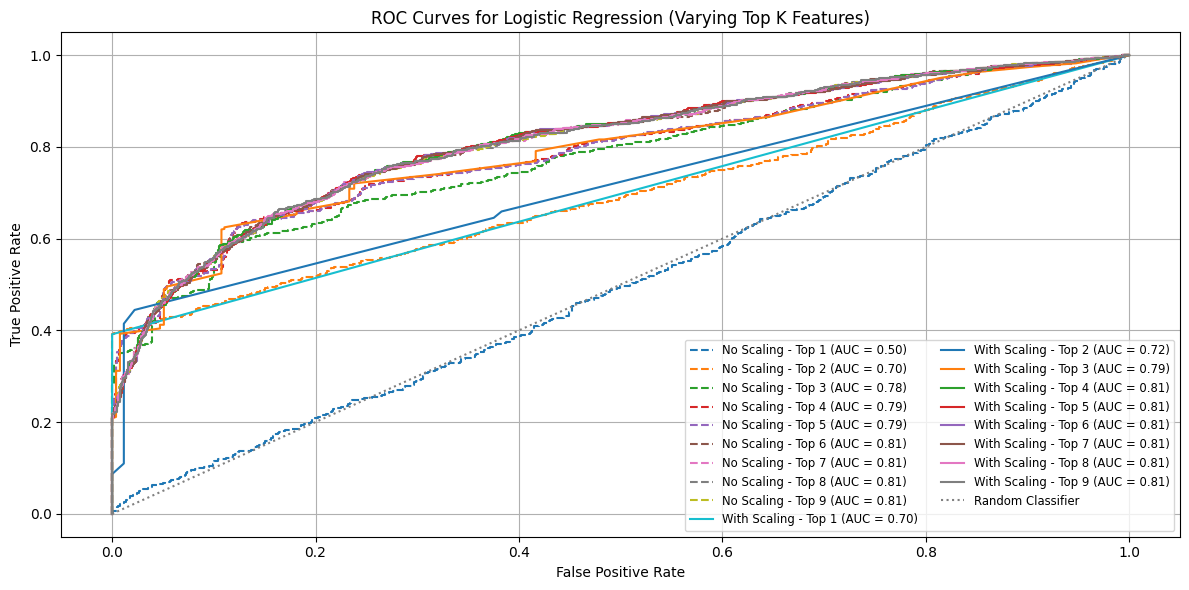

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np


# Load and preview data
df = pd.read_csv("/content/Cybersecurity Intrusion Detection.csv")
# Drop ID column
df = df.drop(columns=["session_id"])

# Summary statistics
print(df.describe(include='all'))

# Split features
X = df.drop("attack_detected", axis=1)
y = df["attack_detected"]
categorical_cols = X.select_dtypes(include="object").columns.tolist()

# Check for null values
print("\nMissing Values:\n", df.isnull().sum())

# Preprocessors
preprocessor_noscale = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
], remainder="passthrough")

preprocessor_scaled = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("scale", MinMaxScaler(), X.select_dtypes(include=["int64", "float64"]).columns.tolist())
])

# Train and test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Plot class distribution
sns.countplot(x='attack_detected', data=df)
plt.title('Intrusion vs Normal Count')
plt.xticks(rotation=45)
plt.show()

# Value counts of target variable
print("\nClass Distribution:\n", df['attack_detected'].value_counts())

# Evaluation function
def evaluate_pipeline(preprocessor, name):
    accs, precs, recalls, f1s, times = [], [], [], [], []
    fprs_all, tprs_all, aucs_all = [], [], []
    model = None

    for k in range(1, 10):
        pipeline = Pipeline([
            ("pre", preprocessor),
            ("select", SelectKBest(score_func=chi2, k=k)),
            ("model", LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000))
        ])

        start_time = time.time()

        if name == "With Scaling":
            X_train_processed = pipeline.named_steps['pre'].fit_transform(X_train_raw, y_train)
            X_train_processed = np.abs(X_train_processed)
            X_test_processed = pipeline.named_steps['pre'].transform(X_test_raw)
            X_test_processed = np.abs(X_test_processed)

            pipeline.named_steps['select'].fit(X_train_processed, y_train)
            X_train_selected = pipeline.named_steps['select'].transform(X_train_processed)
            X_test_selected = pipeline.named_steps['select'].transform(X_test_processed)

            pipeline.named_steps['model'].fit(X_train_selected, y_train)
            y_pred = pipeline.named_steps['model'].predict(X_test_selected)
            y_proba = pipeline.named_steps['model'].predict_proba(X_test_selected)[:, 1]
        else:
            pipeline.fit(X_train_raw, y_train)
            y_pred = pipeline.predict(X_test_raw)
            y_proba = pipeline.predict_proba(X_test_raw)[:, 1]


        elapsed = time.time() - start_time

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        times.append(elapsed)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        fprs_all.append(fpr)
        tprs_all.append(tpr)
        aucs_all.append(auc)

        model = pipeline.named_steps['model']

        print(f"[{name}] Top {k} features -> "
              f"Time: {elapsed:.4f}s | Acc: {accs[-1]:.4f}, "
              f"Prec: {precs[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1: {f1s[-1]:.4f}, AUC: {auc:.4f}")
 # Only plot confusion matrix for With Scaling and k=9
    if name == "With Scaling":
        final_pipeline = Pipeline([
            ("pre", preprocessor),
            ("select", SelectKBest(score_func=chi2, k=9)),
            ("model", LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000))
        ])

        X_train_processed = preprocessor.fit_transform(X_train_raw, y_train)
        X_train_processed = np.abs(X_train_processed)
        X_test_processed = preprocessor.transform(X_test_raw)
        X_test_processed = np.abs(X_test_processed)

        selector = SelectKBest(score_func=chi2, k=9)
        X_train_selected = selector.fit_transform(X_train_processed, y_train)
        X_test_selected = selector.transform(X_test_processed)

        final_pipeline.named_steps['model'].fit(X_train_selected, y_train)
        y_pred_final = final_pipeline.named_steps['model'].predict(X_test_selected)

        cm = confusion_matrix(y_test, y_pred_final)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix: Logistic Regression (With Scaling, Top 9 Features)")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    return accs, precs, recalls, f1s, times, fprs_all, tprs_all, aucs_all, model


# Evaluate both pipelines
print("\n--- Logistic Regression WITHOUT Scaling ---")
acc_no, prec_no, rec_no, f1_no, time_no, fpr_no, tpr_no, auc_no, lr_no_scaling = evaluate_pipeline(preprocessor_noscale, "No Scaling")


print("\n--- Logistic Regression WITH Scaling + L2 Regularization ---")
acc_scaled, prec_scaled, rec_scaled, f1_scaled, time_scaled, fpr_scaled, tpr_scaled, auc_scaled, lr_with_scaling = evaluate_pipeline(preprocessor_scaled, "With Scaling")


# Display feature importance (moved after evaluate_pipeline calls)
# Get feature names after one-hot encoding and scaling
feature_names = preprocessor_scaled.fit(X).get_feature_names_out()
# Select top 9 features to get all feature importances
selector_scaled = SelectKBest(score_func=chi2, k=9)
X_scaled_abs = np.abs(preprocessor_scaled.fit_transform(X))
selector_scaled.fit(X_scaled_abs, y)
selected_features_mask = selector_scaled.get_support()
selected_feature_names = feature_names[selected_features_mask]

# Now get coefficients for the model trained with scaled data and all 9 features
pipeline_scaled_all_features = Pipeline([
    ("pre", preprocessor_scaled),
    ("select", SelectKBest(score_func=chi2, k=9)),
    ("model", LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=1000))
])
X_scaled_processed = pipeline_scaled_all_features.named_steps['pre'].fit_transform(X, y)
X_scaled_processed_abs = np.abs(X_scaled_processed)
pipeline_scaled_all_features.named_steps['select'].fit(X_scaled_processed_abs, y)
X_scaled_selected_all = pipeline_scaled_all_features.named_steps['select'].transform(X_scaled_processed_abs)
pipeline_scaled_all_features.named_steps['model'].fit(X_scaled_selected_all, y)


feature_importances = pd.DataFrame(pipeline_scaled_all_features.named_steps['model'].coef_[0], index=selected_feature_names, columns=["Importance"])
print("\nFeature Importances (With Scaling, Top 9 Features):")
print(feature_importances)


# Plot metrics
metrics = {
    "Accuracy": (acc_no, acc_scaled),
    "Precision": (prec_no, prec_scaled),
    "Recall": (rec_no, rec_scaled),
    "F1 Score": (f1_no, f1_scaled)
}
colors = ["steelblue", "darkorange"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
for i, (metric, (noscale_vals, scaled_vals)) in enumerate(metrics.items()):
    axs[i].bar([x - 0.15 for x in range(1, 10)], noscale_vals, width=0.3, label="No Scaling", color=colors[0])
    axs[i].bar([x + 0.15 for x in range(1, 10)], scaled_vals, width=0.3, label="With Scaling", color=colors[1])
    axs[i].set_title(f"{metric} vs Number of Features")
    axs[i].set_xlabel("Number of Features Selected")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(range(1, 10))
    axs[i].legend()
    axs[i].grid(axis="y")

plt.tight_layout()
plt.show()

# To Plot the execution time
plt.figure(figsize=(10, 5))
plt.bar([x - 0.15 for x in range(1, 10)], time_no, width=0.3, label="No Scaling", color="purple")
plt.bar([x + 0.15 for x in range(1, 10)], time_scaled, width=0.3, label="With Scaling", color="teal")
plt.title("Execution Time vs Number of Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("Time (seconds)")
plt.xticks(range(1, 10))
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

from joblib import Parallel, delayed
import joblib

#save the model as a pickie in a file
joblib.dump(lr_with_scaling, 'Logistic Regression.pkl')

#ROC AUC
plt.figure(figsize=(12, 6))

# No Scaling
for i in range(9):
    plt.plot(fpr_no[i], tpr_no[i], linestyle='--', label=f'No Scaling - Top {i+1} (AUC = {auc_no[i]:.2f})')

# With Scaling
for i in range(9):
    plt.plot(fpr_scaled[i], tpr_scaled[i], linestyle='-', label=f'With Scaling - Top {i+1} (AUC = {auc_scaled[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression (Varying Top K Features)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


--- Random Forest WITHOUT Scaling ---
[No Scaling] Top 1 features -> Time: 3.4009s | Acc: 0.4953, Prec: 0.4433, Recall: 0.4376, F1: 0.4404, AUC: 0.4933
[No Scaling] Top 2 features -> Time: 1.7154s | Acc: 0.6074, Prec: 0.5645, Recall: 0.5912, F1: 0.5776, AUC: 0.6780
[No Scaling] Top 3 features -> Time: 1.0203s | Acc: 0.7327, Prec: 0.7009, Recall: 0.7171, F1: 0.7089, AUC: 0.8079
[No Scaling] Top 4 features -> Time: 1.1477s | Acc: 0.7621, Prec: 0.7368, Recall: 0.7402, F1: 0.7385, AUC: 0.8321
[No Scaling] Top 5 features -> Time: 1.3112s | Acc: 0.8134, Prec: 0.8899, Recall: 0.6721, F1: 0.7658, AUC: 0.8180
[No Scaling] Top 6 features -> Time: 1.4920s | Acc: 0.8899, Prec: 0.9896, Recall: 0.7656, F1: 0.8633, AUC: 0.8905
[No Scaling] Top 7 features -> Time: 1.5904s | Acc: 0.8873, Prec: 0.9837, Recall: 0.7644, F1: 0.8603, AUC: 0.8836
[No Scaling] Top 8 features -> Time: 1.6434s | Acc: 0.8894, Prec: 0.9852, Recall: 0.7679, F1: 0.8631, AUC: 0.8841
[No Scaling] Top 9 features -> Time: 1.4970s | Ac

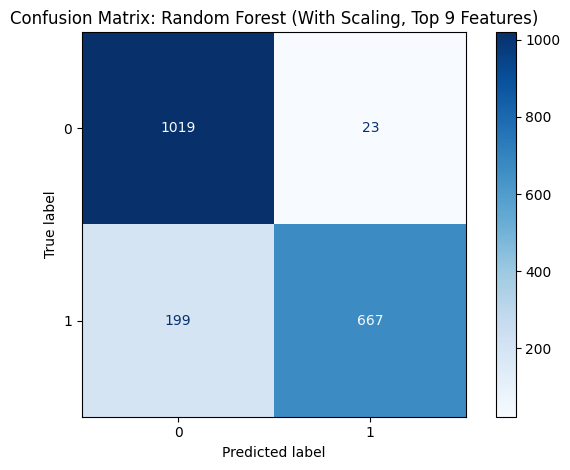

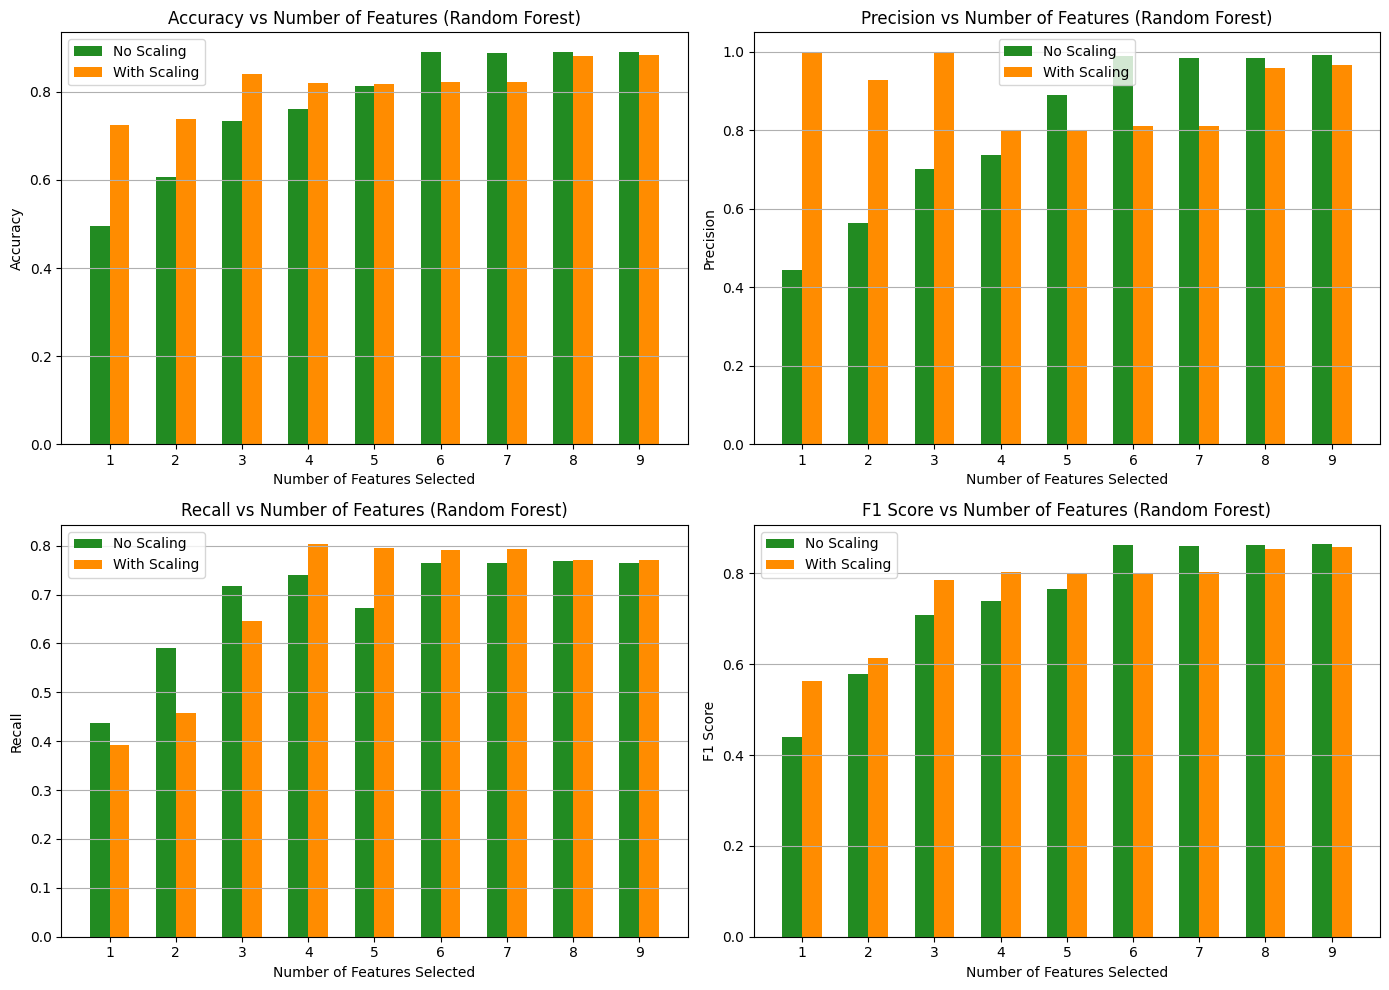

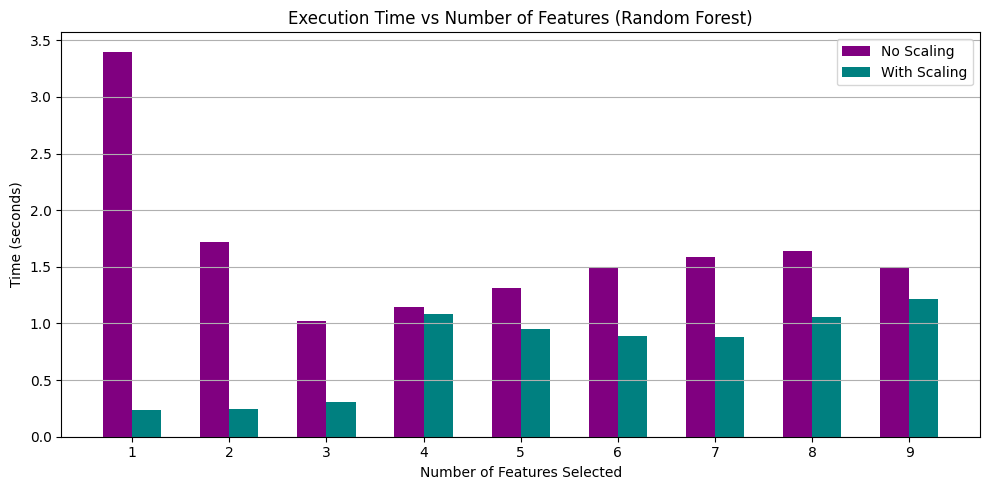

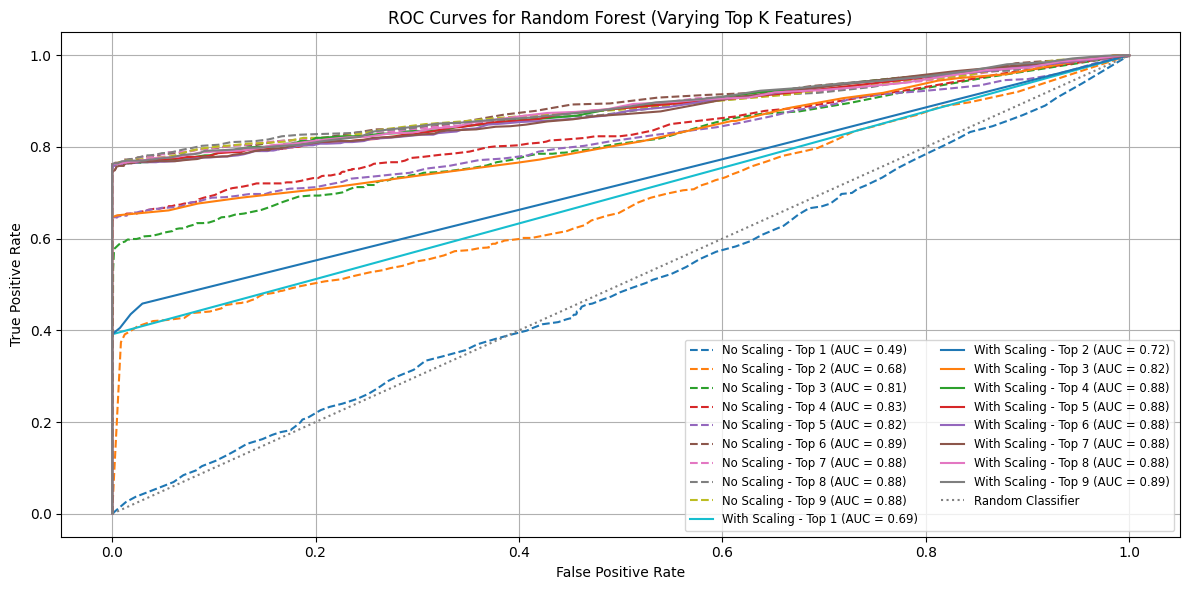

['Random Forest.pkl']

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Evaluation function for Random Forest
def evaluate_rf_pipeline(preprocessor, name):
    accs, precs, recalls, f1s, times = [], [], [], [], []
    fprs_all, tprs_all, aucs_all = [], [], []
    model = None # Initialize model variable

    for k in range(1, 10):
        pipeline = Pipeline([
            ("pre", preprocessor),
            ("select", SelectKBest(score_func=chi2, k=k)),
            ("model", RandomForestClassifier(n_estimators=100, random_state=42))
        ])

        start_time = time.time()

        if name == "With Scaling":
            X_train_processed = pipeline.named_steps['pre'].fit_transform(X_train_raw, y_train)
            X_train_processed = np.abs(X_train_processed)
            X_test_processed = pipeline.named_steps['pre'].transform(X_test_raw)
            X_test_processed = np.abs(X_test_processed)

            pipeline.named_steps['select'].fit(X_train_processed, y_train)
            X_train_selected = pipeline.named_steps['select'].transform(X_train_processed)
            X_test_selected = pipeline.named_steps['select'].transform(X_test_processed)

            pipeline.named_steps['model'].fit(X_train_selected, y_train)
            y_pred = pipeline.named_steps['model'].predict(X_test_selected)
            y_proba = pipeline.named_steps['model'].predict_proba(X_test_selected)[:, 1]
            model = pipeline.named_steps['model'] # Assign model here
        else:
            pipeline.fit(X_train_raw, y_train)
            y_pred = pipeline.predict(X_test_raw)
            y_proba = pipeline.predict_proba(X_test_raw)[:, 1]
            model = pipeline.named_steps['model'] # Assign model here

        elapsed = time.time() - start_time

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        times.append(elapsed)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        fprs_all.append(fpr)
        tprs_all.append(tpr)
        aucs_all.append(auc)


        print(f"[{name}] Top {k} features -> "
              f"Time: {elapsed:.4f}s | Acc: {accs[-1]:.4f}, "
              f"Prec: {precs[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1: {f1s[-1]:.4f}, AUC: {auc:.4f}")

    # Only plot confusion matrix for With Scaling and k=9
    if name == "With Scaling":
        final_pipeline = Pipeline([
            ("pre", preprocessor),
            ("select", SelectKBest(score_func=chi2, k=9)),
            ("model", RandomForestClassifier(n_estimators=100, random_state=42))
        ])

        X_train_processed = preprocessor.fit_transform(X_train_raw, y_train)
        X_train_processed = np.abs(X_train_processed)
        X_test_processed = preprocessor.transform(X_test_raw)
        X_test_processed = np.abs(X_test_processed)

        selector = SelectKBest(score_func=chi2, k=9)
        X_train_selected = selector.fit_transform(X_train_processed, y_train)
        X_test_selected = selector.transform(X_test_processed)

        final_pipeline.named_steps['model'].fit(X_train_selected, y_train)
        y_pred_final = final_pipeline.named_steps['model'].predict(X_test_selected)

        cm = confusion_matrix(y_test, y_pred_final)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix: Random Forest (With Scaling, Top 9 Features)")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    return accs, precs, recalls, f1s, times, fprs_all, tprs_all, aucs_all, model # Return model


# Run evaluations
print("\n--- Random Forest WITHOUT Scaling ---")
acc_no, prec_no, rec_no, f1_no, time_no, fpr_no, tpr_no, auc_no, rf_no_scaling = evaluate_rf_pipeline(preprocessor_noscale, "No Scaling") # Assign returned model

print("\n--- Random Forest WITH Scaling ---")
acc_scaled, prec_scaled, rec_scaled, f1_scaled, time_scaled, fpr_scaled, tpr_scaled, auc_scaled, rf_with_scaling = evaluate_rf_pipeline(preprocessor_scaled, "With Scaling") # Assign returned model

# Plot metric comparisons
metrics = {
    "Accuracy": (acc_no, acc_scaled),
    "Precision": (prec_no, prec_scaled),
    "Recall": (rec_no, rec_scaled),
    "F1 Score": (f1_no, f1_scaled)
}
colors = ["forestgreen", "darkorange"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
for i, (metric, (noscale_vals, scaled_vals)) in enumerate(metrics.items()):
    axs[i].bar([x - 0.15 for x in range(1, 10)], noscale_vals, width=0.3, label="No Scaling", color=colors[0])
    axs[i].bar([x + 0.15 for x in range(1, 10)], scaled_vals, width=0.3, label="With Scaling", color=colors[1])
    axs[i].set_title(f"{metric} vs Number of Features (Random Forest)")
    axs[i].set_xlabel("Number of Features Selected")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(range(1, 10))
    axs[i].legend()
    axs[i].grid(axis="y")

plt.tight_layout()
plt.show()

# Execution time
plt.figure(figsize=(10, 5))
plt.bar([x - 0.15 for x in range(1, 10)], time_no, width=0.3, label="No Scaling", color="purple")
plt.bar([x + 0.15 for x in range(1, 10)], time_scaled, width=0.3, label="With Scaling", color="teal")
plt.title("Execution Time vs Number of Features (Random Forest)")
plt.xlabel("Number of Features Selected")
plt.ylabel("Time (seconds)")
plt.xticks(range(1, 10))
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ROC-AUC curves
plt.figure(figsize=(12, 6))
for i in range(9):
    plt.plot(fpr_no[i], tpr_no[i], linestyle='--', label=f'No Scaling - Top {i+1} (AUC = {auc_no[i]:.2f})')
for i in range(9):
    plt.plot(fpr_scaled[i], tpr_scaled[i], linestyle='-', label=f'With Scaling - Top {i+1} (AUC = {auc_scaled[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest (Varying Top K Features)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

from joblib import Parallel, delayed
import joblib

#save the model as a pickie in a file
joblib.dump(rf_with_scaling, 'Random Forest.pkl')


--- Decision Tree WITHOUT Scaling ---
[No Scaling] Top 1 features -> Time: 0.0448s | Acc: 0.5466, Prec: 0.5029, Recall: 0.1016, F1: 0.1691, AUC: 0.5236
[No Scaling] Top 2 features -> Time: 0.0393s | Acc: 0.7138, Prec: 0.9020, Recall: 0.4145, F1: 0.5680, AUC: 0.6931
[No Scaling] Top 3 features -> Time: 0.0399s | Acc: 0.8071, Prec: 0.9478, Recall: 0.6085, F1: 0.7412, AUC: 0.7966
[No Scaling] Top 4 features -> Time: 0.0384s | Acc: 0.8265, Prec: 0.9421, Recall: 0.6582, F1: 0.7750, AUC: 0.8239
[No Scaling] Top 5 features -> Time: 0.0476s | Acc: 0.8276, Prec: 0.9453, Recall: 0.6582, F1: 0.7760, AUC: 0.8274
[No Scaling] Top 6 features -> Time: 0.0561s | Acc: 0.8910, Prec: 0.9867, Recall: 0.7702, F1: 0.8651, AUC: 0.8786
[No Scaling] Top 7 features -> Time: 0.0550s | Acc: 0.8920, Prec: 0.9882, Recall: 0.7714, F1: 0.8664, AUC: 0.8790
[No Scaling] Top 8 features -> Time: 0.0544s | Acc: 0.8910, Prec: 0.9867, Recall: 0.7702, F1: 0.8651, AUC: 0.8780
[No Scaling] Top 9 features -> Time: 0.0655s | Ac

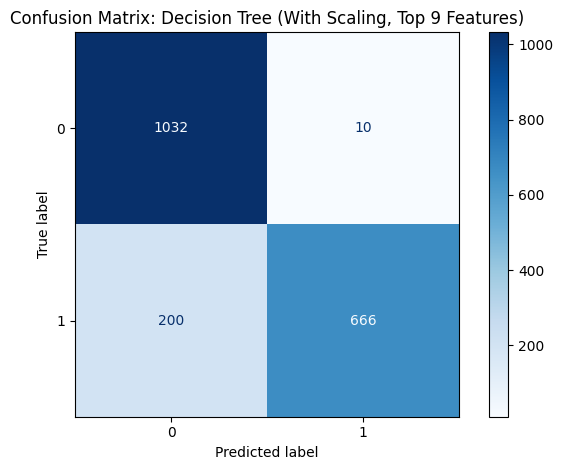

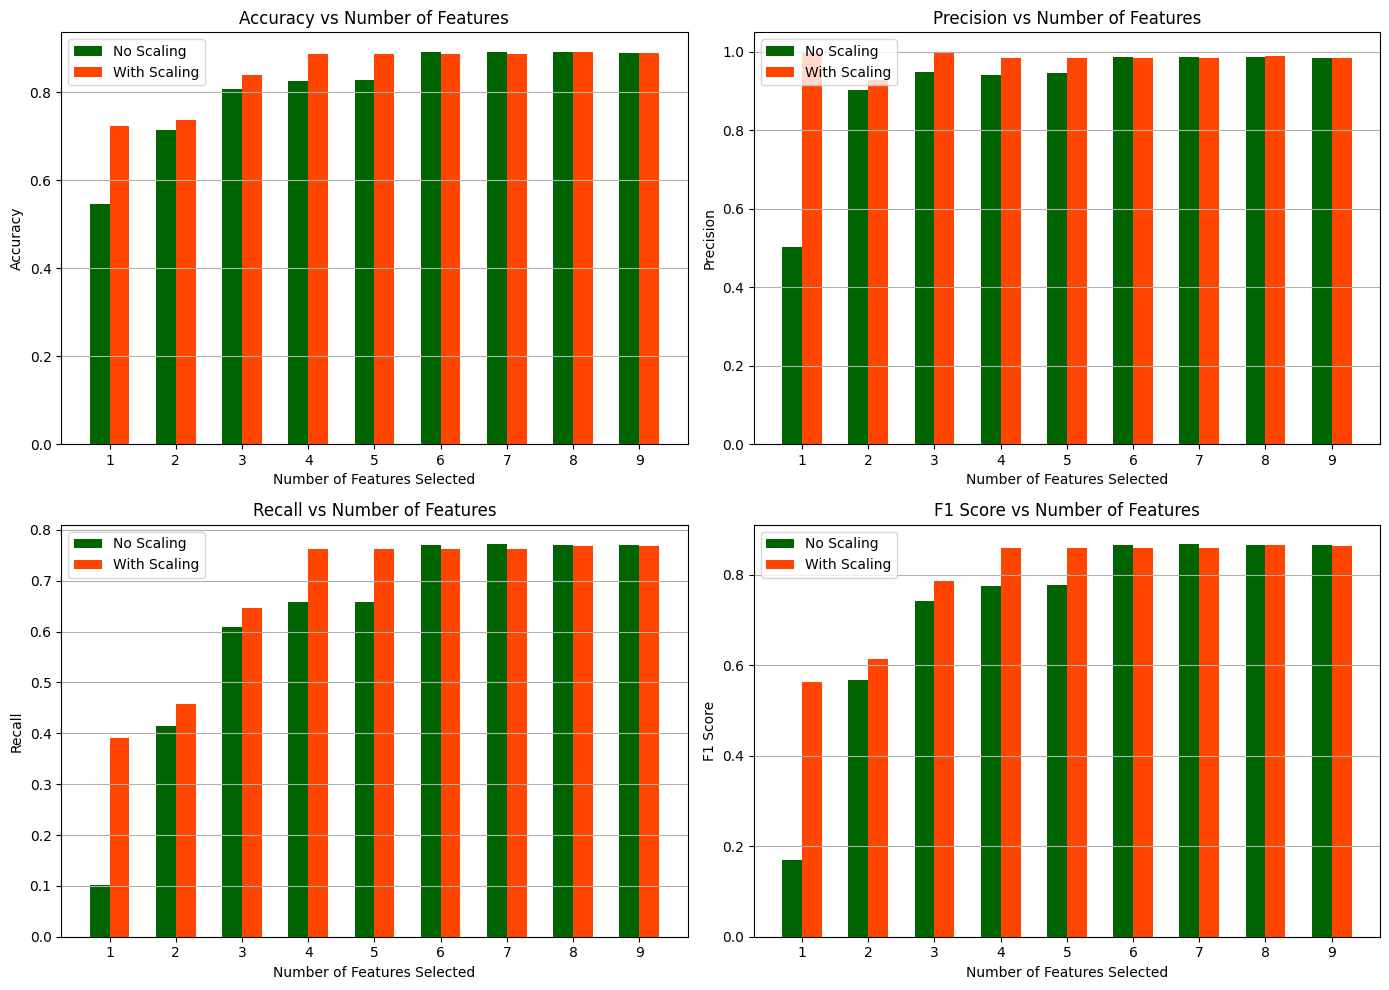

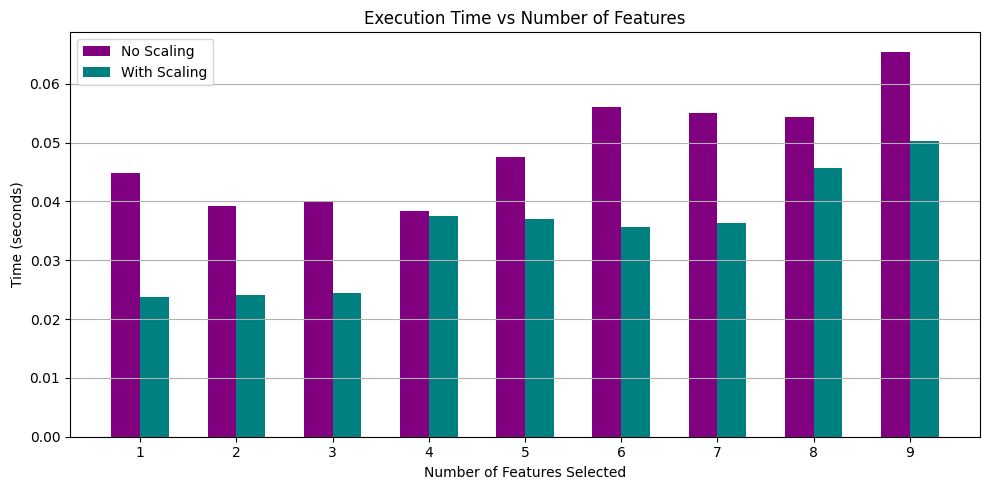

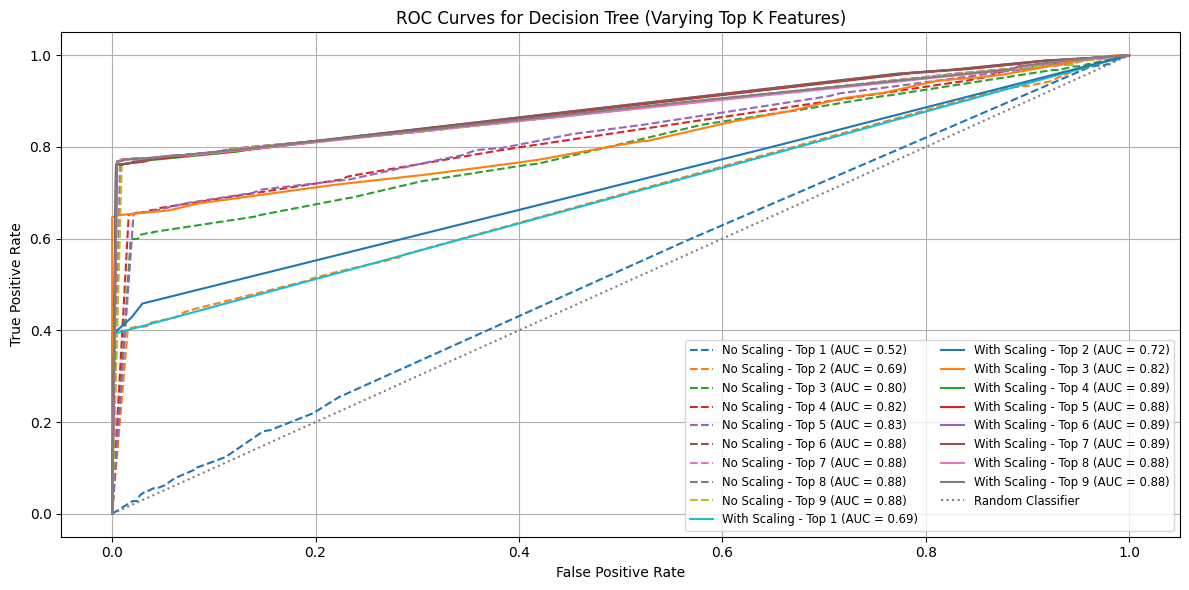

['Decision Tree.pkl']

In [10]:
from sklearn.tree import DecisionTreeClassifier


# Evaluation function
def evaluate_pipeline(preprocessor, name):
    accs, precs, recalls, f1s, times = [], [], [], [], []
    fprs_all, tprs_all, aucs_all = [], [], []
    model = None

    for k in range(1, 10):
        pipeline = Pipeline([
            ("pre", preprocessor),
            ("select", SelectKBest(score_func=chi2, k=k)),
            ("model", DecisionTreeClassifier(max_depth=10, random_state=42))
        ])

        start_time = time.time()

        if name == "With Scaling":
            X_train_processed = pipeline.named_steps['pre'].fit_transform(X_train_raw, y_train)
            X_train_processed = np.abs(X_train_processed)
            X_test_processed = pipeline.named_steps['pre'].transform(X_test_raw)
            X_test_processed = np.abs(X_test_processed)

            pipeline.named_steps['select'].fit(X_train_processed, y_train)
            X_train_selected = pipeline.named_steps['select'].transform(X_train_processed)
            X_test_selected = pipeline.named_steps['select'].transform(X_test_processed)

            pipeline.named_steps['model'].fit(X_train_selected, y_train)
            y_pred = pipeline.named_steps['model'].predict(X_test_selected)
            y_proba = pipeline.named_steps['model'].predict_proba(X_test_selected)[:, 1]
        else:
            pipeline.fit(X_train_raw, y_train)
            y_pred = pipeline.predict(X_test_raw)
            y_proba = pipeline.predict_proba(X_test_raw)[:, 1]

        elapsed = time.time() - start_time

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        times.append(elapsed)

        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        fprs_all.append(fpr)
        tprs_all.append(tpr)
        aucs_all.append(auc)

        model = pipeline.named_steps['model']

        print(f"[{name}] Top {k} features -> "
              f"Time: {elapsed:.4f}s | Acc: {accs[-1]:.4f}, "
              f"Prec: {precs[-1]:.4f}, Recall: {recalls[-1]:.4f}, F1: {f1s[-1]:.4f}, AUC: {auc:.4f}")

    # Confusion Matrix for best (With Scaling, k=9)
    if name == "With Scaling":
        final_pipeline = Pipeline([
            ("pre", preprocessor),
            ("select", SelectKBest(score_func=chi2, k=9)),
            ("model", DecisionTreeClassifier(max_depth=10, random_state=42))
        ])

        X_train_processed = preprocessor.fit_transform(X_train_raw, y_train)
        X_train_processed = np.abs(X_train_processed)
        X_test_processed = preprocessor.transform(X_test_raw)
        X_test_processed = np.abs(X_test_processed)

        selector = SelectKBest(score_func=chi2, k=9)
        X_train_selected = selector.fit_transform(X_train_processed, y_train)
        X_test_selected = selector.transform(X_test_processed)

        final_pipeline.named_steps['model'].fit(X_train_selected, y_train)
        y_pred_final = final_pipeline.named_steps['model'].predict(X_test_selected)

        cm = confusion_matrix(y_test, y_pred_final)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title("Confusion Matrix: Decision Tree (With Scaling, Top 9 Features)")
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    return accs, precs, recalls, f1s, times, fprs_all, tprs_all, aucs_all, model


# Evaluate pipelines
print("\n--- Decision Tree WITHOUT Scaling ---")
acc_no, prec_no, rec_no, f1_no, time_no, fpr_no, tpr_no, auc_no, dt_no_scaling = evaluate_pipeline(preprocessor_noscale, "No Scaling")

print("\n--- Decision Tree WITH Scaling ---")
acc_scaled, prec_scaled, rec_scaled, f1_scaled, time_scaled, fpr_scaled, tpr_scaled, auc_scaled, dt_with_scaling = evaluate_pipeline(preprocessor_scaled, "With Scaling")




# Plot metrics
metrics = {
    "Accuracy": (acc_no, acc_scaled),
    "Precision": (prec_no, prec_scaled),
    "Recall": (rec_no, rec_scaled),
    "F1 Score": (f1_no, f1_scaled)
}
colors = ["darkgreen", "orangered"]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
for i, (metric, (noscale_vals, scaled_vals)) in enumerate(metrics.items()):
    axs[i].bar([x - 0.15 for x in range(1, 10)], noscale_vals, width=0.3, label="No Scaling", color=colors[0])
    axs[i].bar([x + 0.15 for x in range(1, 10)], scaled_vals, width=0.3, label="With Scaling", color=colors[1])
    axs[i].set_title(f"{metric} vs Number of Features")
    axs[i].set_xlabel("Number of Features Selected")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(range(1, 10))
    axs[i].legend()
    axs[i].grid(axis="y")

plt.tight_layout()
plt.show()

# Execution time
plt.figure(figsize=(10, 5))
plt.bar([x - 0.15 for x in range(1, 10)], time_no, width=0.3, label="No Scaling", color="purple")
plt.bar([x + 0.15 for x in range(1, 10)], time_scaled, width=0.3, label="With Scaling", color="teal")
plt.title("Execution Time vs Number of Features")
plt.xlabel("Number of Features Selected")
plt.ylabel("Time (seconds)")
plt.xticks(range(1, 10))
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ROC AUC curves
plt.figure(figsize=(12, 6))
for i in range(9):
    plt.plot(fpr_no[i], tpr_no[i], linestyle='--', label=f'No Scaling - Top {i+1} (AUC = {auc_no[i]:.2f})')
for i in range(9):
    plt.plot(fpr_scaled[i], tpr_scaled[i], linestyle='-', label=f'With Scaling - Top {i+1} (AUC = {auc_scaled[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree (Varying Top K Features)')
plt.legend(loc='lower right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

from joblib import Parallel, delayed
import joblib

#save the model as a pickie in a file
joblib.dump(dt_with_scaling, 'Decision Tree.pkl')


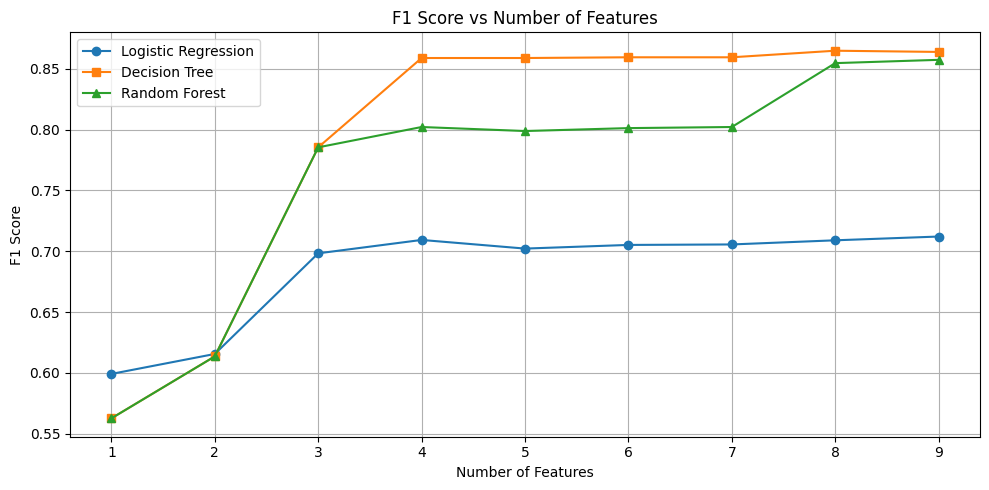

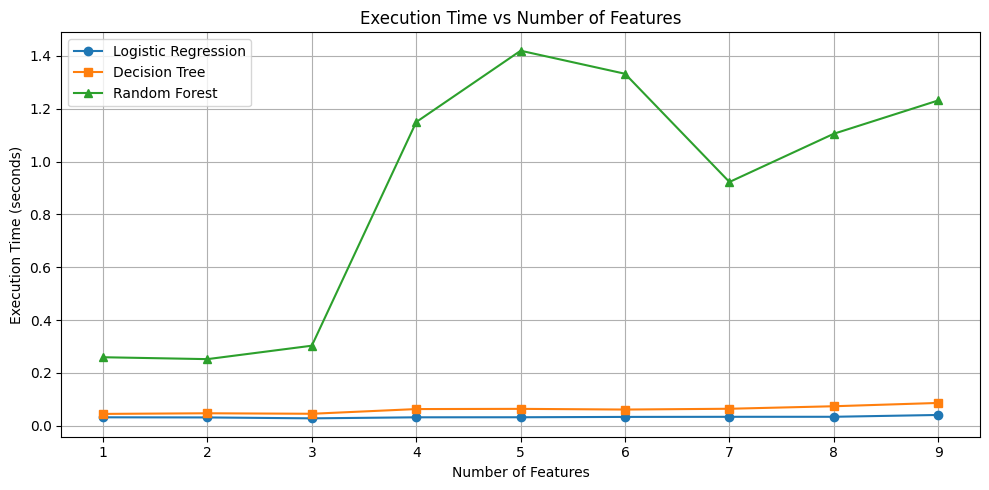

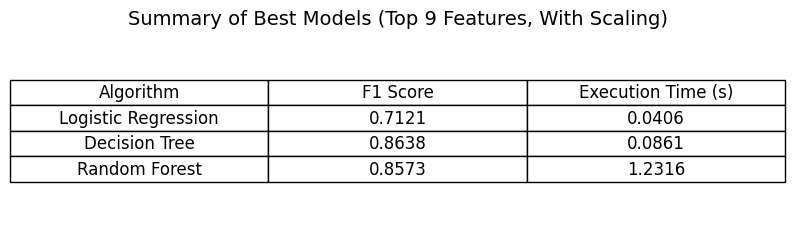

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Number of features
features = list(range(1, 10))

#Logistic Regression
f1_lr_scaled = [0.5992, 0.6156, 0.6983, 0.7093, 0.7022, 0.7052, 0.7056, 0.7090, 0.7121]
time_lr_scaled = [0.0317, 0.0312, 0.0278, 0.0317, 0.0319, 0.0332, 0.0336, 0.0337, 0.0406]

# Random Forest
f1_rf_scaled = [0.5627, 0.6136, 0.7854, 0.8021, 0.7988, 0.8012, 0.8021, 0.8546, 0.8573]
time_rf_scaled = [0.2592, 0.2520, 0.3029, 1.1498, 1.4199, 1.3326, 0.9228, 1.1055, 1.2316]

# Decision Tree
f1_dt_scaled = [0.5627, 0.6136, 0.7854, 0.8588, 0.8588, 0.8594, 0.8594, 0.8648, 0.8638]
time_dt_scaled = [0.0446, 0.0470, 0.0451, 0.0629, 0.0637, 0.0611, 0.0641, 0.0736, 0.0861]

# PLOT: F1 Score vs Number of Features
plt.figure(figsize=(10, 5))
plt.plot(features, f1_lr_scaled, marker='o', label='Logistic Regression')
plt.plot(features, f1_dt_scaled, marker='s', label='Decision Tree')
plt.plot(features, f1_rf_scaled, marker='^', label='Random Forest')
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Number of Features")
plt.grid(True)
plt.xticks(features)
plt.legend()
plt.tight_layout()
plt.show()

# PLOT: Execution Time vs Number of Features
plt.figure(figsize=(10, 5))
plt.plot(features, time_lr_scaled, marker='o', label='Logistic Regression')
plt.plot(features, time_dt_scaled, marker='s', label='Decision Tree')
plt.plot(features, time_rf_scaled, marker='^', label='Random Forest')
plt.xlabel("Number of Features")
plt.ylabel("Execution Time (seconds)")
plt.title("Execution Time vs Number of Features")
plt.grid(True)
plt.xticks(features)
plt.legend()
plt.tight_layout()
plt.show()

# SUMMARY TABLE (Based on 9 Features)
summary_data = {
    "Algorithm": ["Logistic Regression", "Decision Tree", "Random Forest"],
    "F1 Score": [f1_lr_scaled[-1], f1_dt_scaled[-1], f1_rf_scaled[-1]],
    "Execution Time (s)": [time_lr_scaled[-1], time_dt_scaled[-1], time_rf_scaled[-1]]
}

summary_df = pd.DataFrame(summary_data)

# Plot summary as a table
fig, ax = plt.subplots(figsize=(8, 2.5))
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title("Summary of Best Models (Top 9 Features, With Scaling)", fontsize=14)
plt.tight_layout()
plt.show()
